<a href="https://colab.research.google.com/github/SEAFARI/pytorch-deeplearning/blob/main/06_Pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Transfer Learning

What is transfer Learning??

Transfer Learning involves taking the parameters of what one model has learned
on another dataset and applying it to our own problem.

Pretrained model = foundation model




In [1]:
import torch
import torchvision

In [2]:
## Checking the versions
print(torch.__version__ )
print(torchvision.__version__ )

2.9.0+cu126
0.24.0+cu126


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 28.19 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [4]:
## setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
## check gpu
!nvidia-smi

Wed Nov 26 08:40:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Get the data

In [6]:
from torch.utils import data
import os
import zipfile

from pathlib import Path
import requests

## setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

## if image folder dosent exist then downlaod from github
if image_path.is_dir():
  print(f"{image_path} directory exists. Skipping re-download....")
else:
  print(f"Couldn't find {image_path}, Downloading it....")
  image_path.mkdir(parents=True, exist_ok=True)

  ## Download from github
  with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data.... ")
    f.write(request.content)

  ## unzip pizza_steak_sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza steak sushi data")
    zip_ref.extractall(image_path)


    ## Remove the zip file
    os.remove(data_path/"pizza_steak_sushi.zip" )

Couldn't find data/pizza_steak_sushi, Downloading it....
Unzipping pizza steak sushi data


In [7]:
## setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 3. Create Datasets and Dataloaders

we'll use `data_setup.py` and the `create_dataloaders()` function created in
going modular section


### 2.1 Creating a transform for `torchvision.models` (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of:

| **Transform number** | **Transform required** | **Code to perform transform** |
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  |

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [8]:
from torchvision import transforms

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [9]:
## 2. Create Datasets and Dataloaders

from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

In [10]:
class_names

['pizza', 'steak', 'sushi']

### 2.1 Creating a transform for `torchvision.models` (automatic creation)

If we are creating transforms manually and any errors can cause problems. Thus torch V 0.13+ supports automatic transform based on the pretrained model weights you're using.

Docs: https://docs.pytorch.org/vision/master/models.html#classification

In [11]:
import torch
torchvision.__version__

'0.24.0+cu126'

In [12]:
## get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" -> Best available weights

## e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'  --> check out docs
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
## Get the transforms used to create our pre trained weights
auto_transforms = weights.transforms()
auto_transforms  ## automatically created transforms

## crop_size = resize

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
## Create dataloaders with automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

In [15]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7de565fb1ca0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

*Experiment, Experiement, Experiement*

Things to consider:
1. Speed - how fast it needs to run ?
2. Performance - how well it goes with our chosen problem?
3. size - how big is the model?

See best accuracy with less number of parameters - for high speed and performance and size

for mobile there is also mobilenet

If we had infinite computation power - we'd likely pick the biggest model + most parameters + most geneal we could ( neural networks are general ) - https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf

Where to get the models from ?

1. Huggingface
2. torchvision.models - https://docs.pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights
3. Libraries in `timm` (torch image models)


## 3.2. Setting up a pretrained model

Want to create an instance of a pretrained EFFNet_B0 - https://docs.pytorch.org/vision/0.24/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0


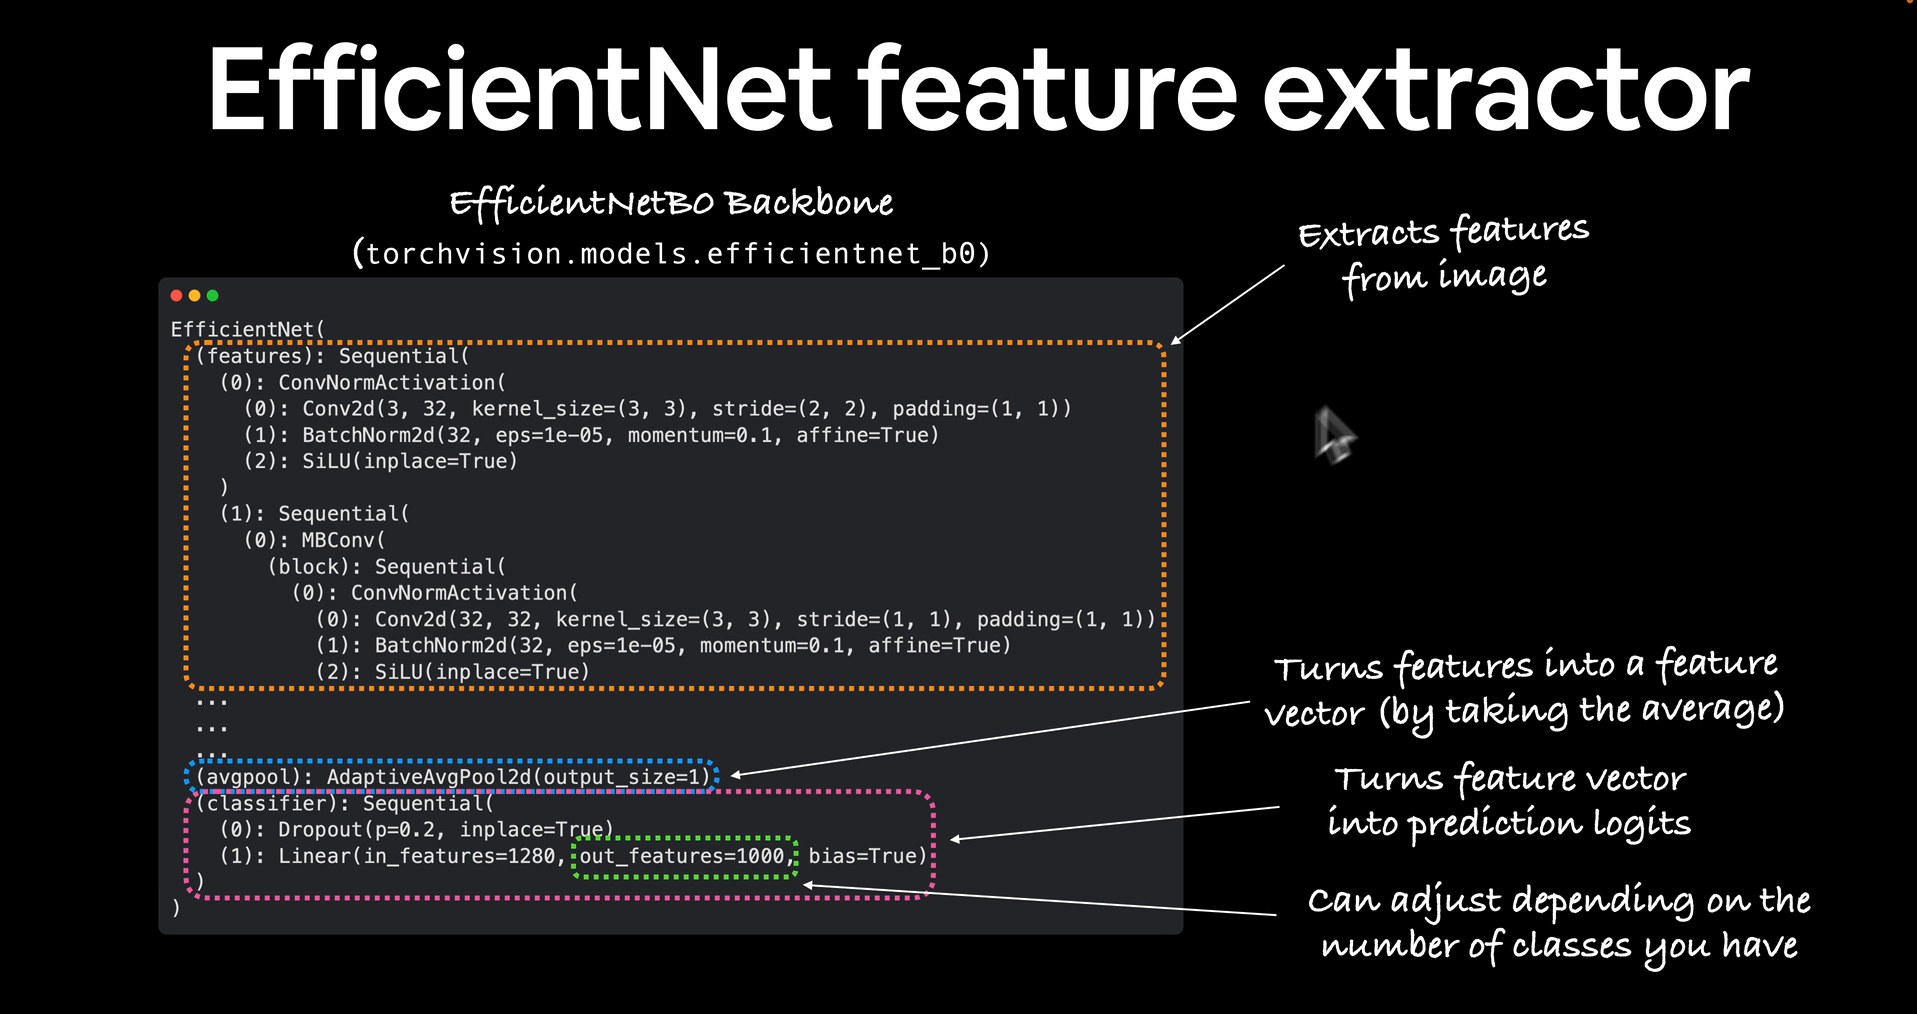

In [16]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT ## ".DEFAULT" -> best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


In [17]:
model # check out how many layers are here -> someone has handcrafted these layers

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
model.features ## extract patterns from the image -> using patterns learned on imagenet -> might be a big tensor

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [19]:
model.avgpool ## compress the feautures into a single vector of size 1280
## big tensor -> vector

AdaptiveAvgPool2d(output_size=1)

In [20]:
model.classifier  ## **classfier head that we'll modify for our problem**

"""
Here by deafault, there are 1000 output features since imagenet1k -> trained on 1000 classes
We need to make it to 3 -> pizza, steak, sushi
base layers stay frozen -> dont update during training
change the input data and output head
"""

'\nHere by deafault, there are 1000 output features since imagenet1k -> trained on 1000 classes\nWe need to make it to 3 -> pizza, steak, sushi\nbase layers stay frozen -> dont update during training\nchange the input data and output head\n'

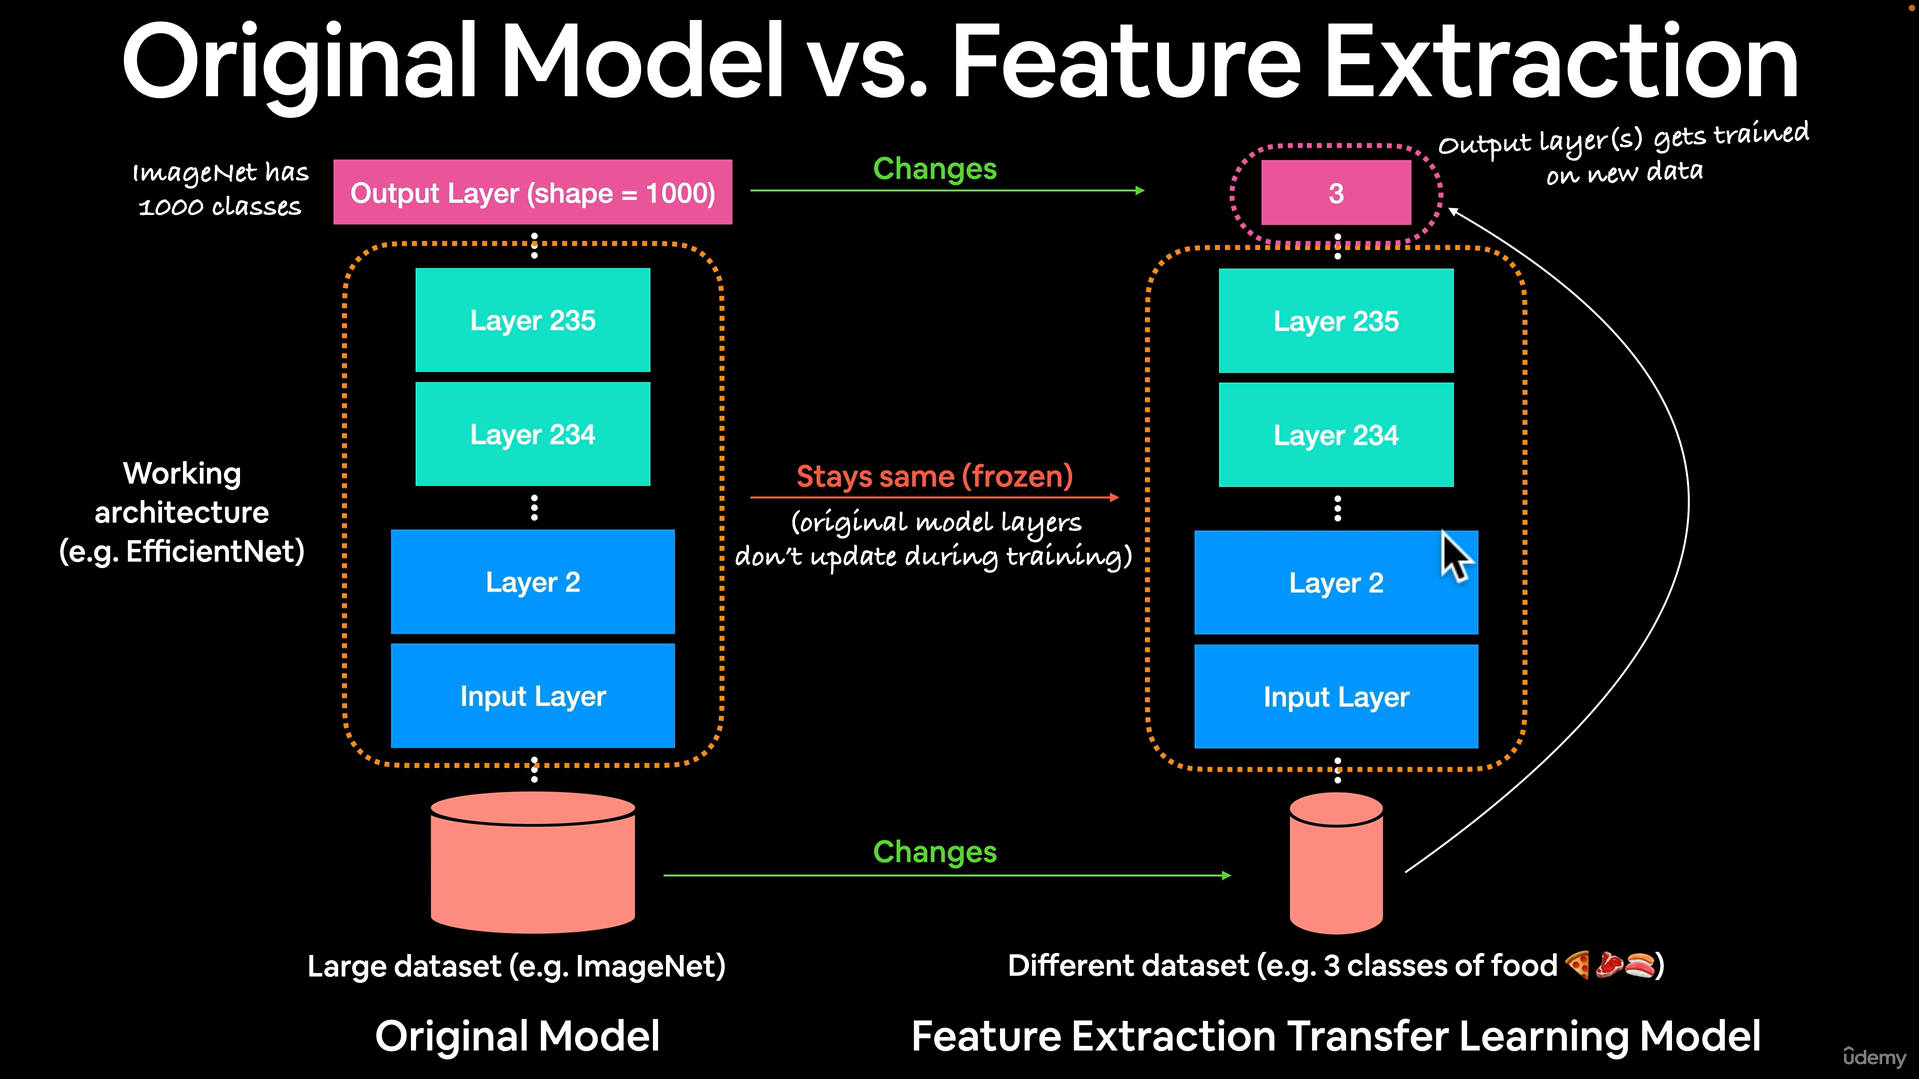



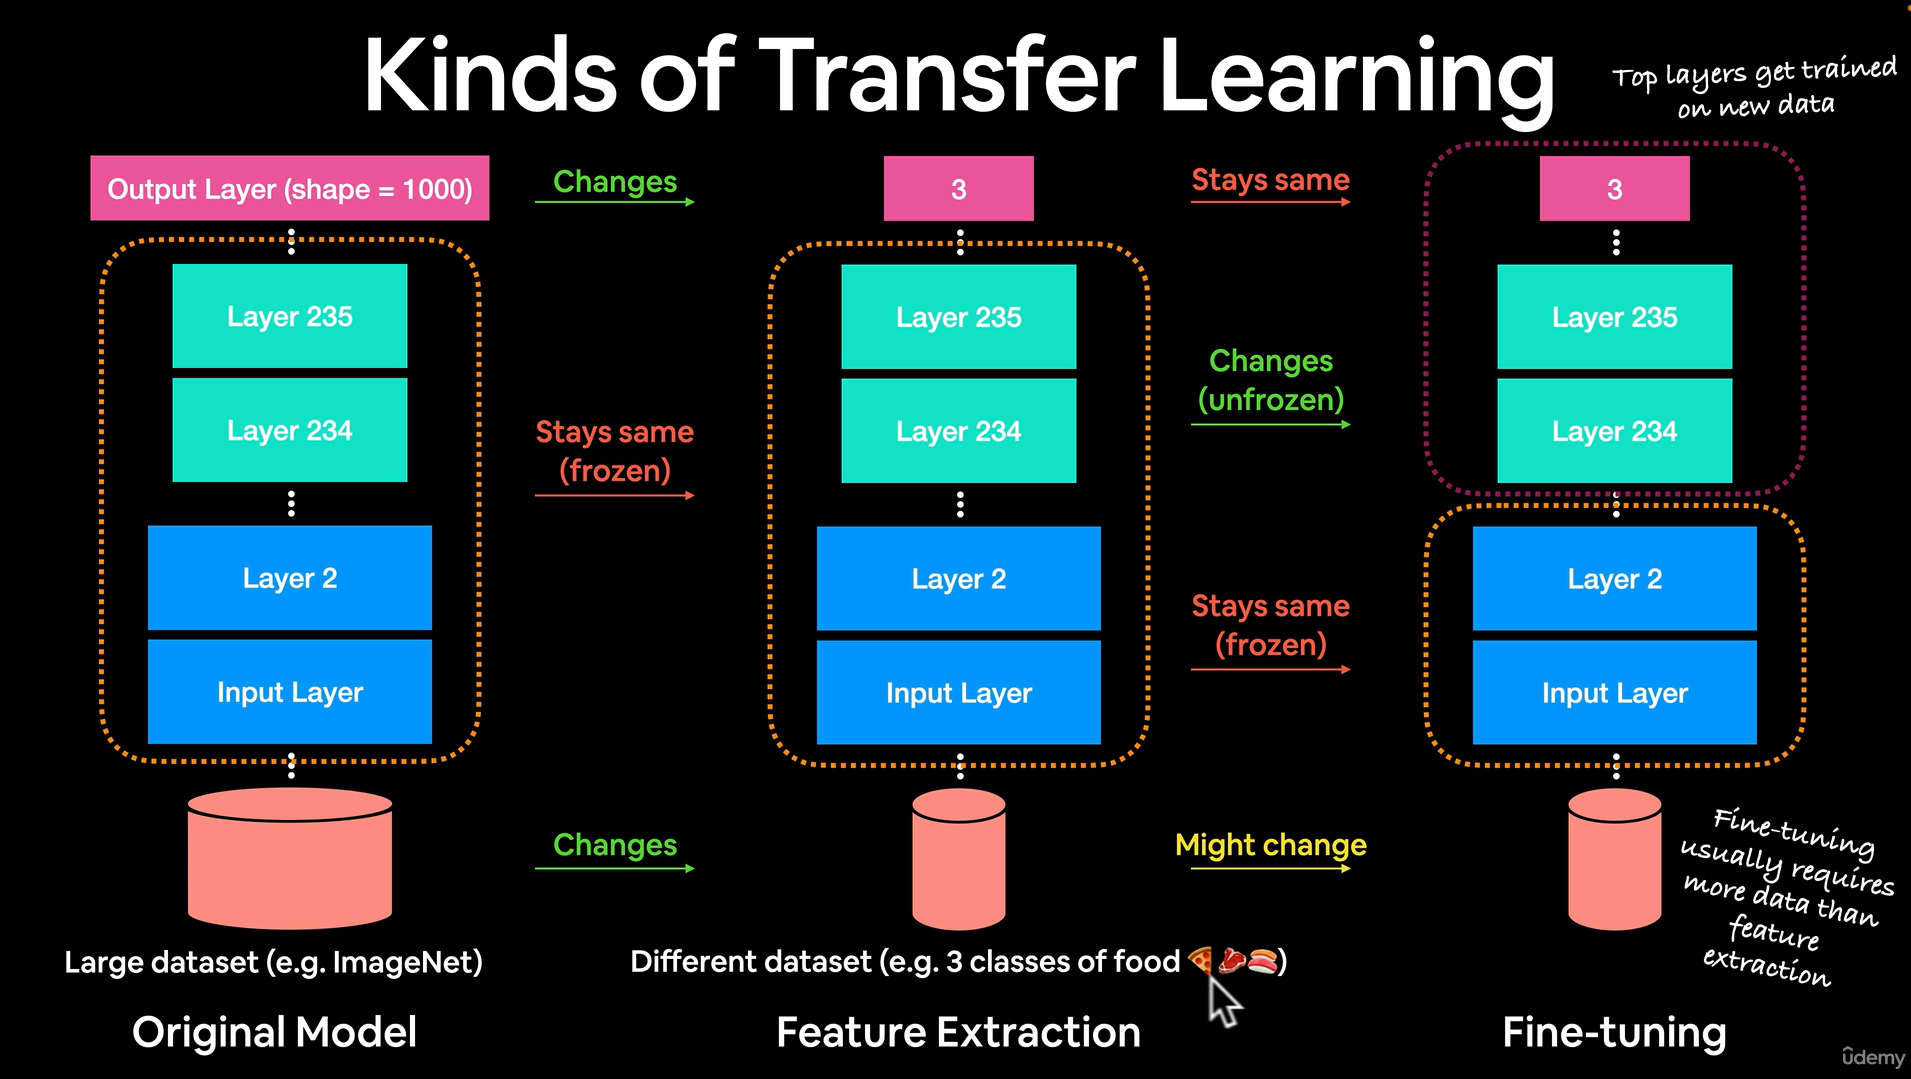



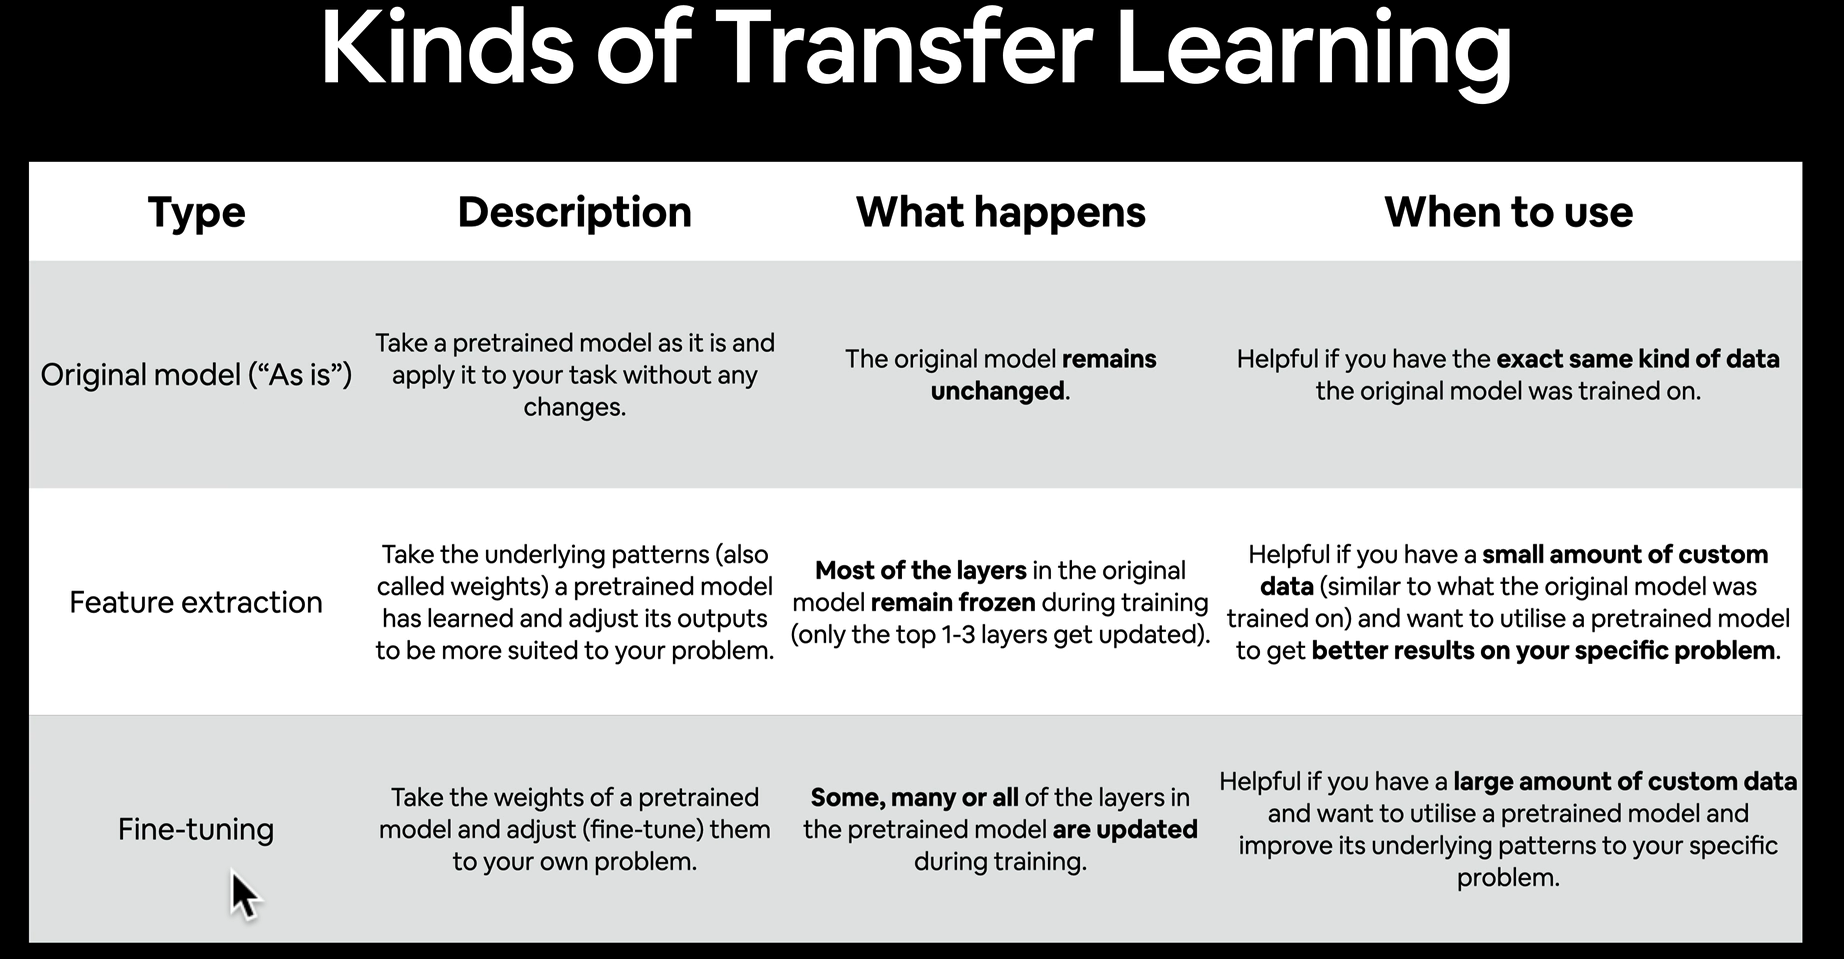
we can perform `fine tuning` when we have large amounts of data. Ex: 1000 images per class. our data has around 100 images.

Order stays same:
original model -> feature extraction -> fine tuning (layer by layer)

## 3.3. Getting a summary of our model with `torchinfo.summary()`

| Parameter | Type | Default | Short description | Supported values / notes |
|---|---:|---|---|---|
| model | `nn.Module` | — | PyTorch model to summarize | — |
| input_size | `Sequence` (tuple/list/torch.Size) | `None` | Shape of input including batch dim (used to generate fake input) | e.g. `(1,3,224,224)` |
| input_data | `Sequence[Tensors]` | `None` | Actual input tensors (pass args list or dict kwargs) | If provided, dtypes inferred |
| batch_dim | `int` | `None` | Which axis is batch dim (optimizes forward pass when set) | If `None`, batch dim assumed in `input_size` |
| cache_forward_pass | `bool` | `False` | Cache forward pass to avoid re-running expensive forward | Warning: cache may become stale if model/input change |
| col_names | `Iterable[str]` | `("output_size","num_params")` | Which columns to display in the summary | Supported: `"input_size"`, `"output_size"`, `"num_params"`, `"params_percent"`, `"kernel_size"`, `"groups"`, `"mult_adds"`, `"trainable"` |
| col_width | `int` | `25` | Column width (characters) | — |
| depth | `int` | `3` | How many nested layer levels to show | Lower hides deeper nested modules |
| device | `torch.device` | `None` | Device used for model & inputs during summary | If `None` inferred from inputs/params or `torch.cuda.is_available()` |
| dtypes | `List[torch.dtype]` | `None` | Data types for `input_size` (if not float) | Provide one per input when multiple inputs |
| mode | `str` | `"same"` | Whether to call `model.train()` / `model.eval()` during summary | `"train"`, `"eval"`, or `"same"` |
| row_settings | `Iterable[str]` | `("depth",)` | Extra row info to show for each layer | Supported: `"ascii_only"`, `"depth"`, `"var_names"` |
| verbose | `int` | `1` (0/1/2) | Output verbosity | `0`=quiet, `1`=print summary, `2`=show weights & bias layers |
| **kwargs | Any | — | Forward-pass kwargs passed to model.forward | Passing *args is no longer supported |
| Return | `ModelStatistics` | — | Object containing the full summary (stringable) | See `torchinfo/model_statistics.py` |


In [21]:
!pip install torchinfo

In [22]:
## print a summary
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224), # example of [bacth_size, colour_channels, height, width]
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In the above summary that all the layers are trainable. We'll need to freeze all these layers so that only the input and output are trainable.

## 3.4. Freezing the base model and changing the output layer to suite our needs.

with a feature extractor model typically you will "freeze" the base layers of a pre-trained model and update the output layers to suit your own problem.

In [23]:
for param in model.features.parameters():
  print(param)   ## pre learned weights, params learned on imagenet ## requres_grad is true


Streaming output truncated to the last 5000 lines.
         0.7560,  0.4746,  1.3832,  0.7507,  1.3164,  0.5835,  0.3116,  1.7398,
         1.1663,  0.4408,  0.8997,  1.0494,  1.3308,  1.4908,  1.0511,  2.3254,
         1.1091,  1.2917,  0.9891,  0.7814,  0.8032,  0.1800,  1.6238,  0.2936,
         2.2015,  1.4586,  0.5483,  0.8732,  1.3206,  1.1712,  1.3641,  0.9836,
         1.2178,  1.3223,  0.8376,  1.6825,  1.0741,  1.5837,  0.9248,  0.1340,
         0.8932,  1.3822,  1.8459,  1.3185,  0.8514,  1.4013,  1.0366,  0.1742,
         0.0927,  0.7876,  0.5567,  1.0097,  1.8741,  0.1025,  0.2074, -0.0827,
         0.8755,  0.5561,  0.7710,  0.9371,  0.9282,  1.1824,  1.8135,  0.0504,
         1.7317,  1.2897, -0.2217,  1.1973,  0.1873,  1.0048,  0.8866,  1.2479,
         1.5787,  1.4295,  0.7512,  0.6180,  1.3923,  2.2133,  1.3218,  0.1716,
         1.9541,  1.1642,  0.0937,  1.7798,  1.2972,  0.0682,  2.0200,  0.7387,
         1.1553,  0.7711,  1.3212,  1.6540,  0.0968,  0.4048,  1.5387

In [24]:
 ## Freeze all the base layers in Effnet_B0
for param in model.features.parameters():
  # print(param)
  param.requires_grad= False


In [25]:
## update the classifier head to suit our problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280, ## feature vector coming in, p=0.2 means 20% of values in this 1280 vector will be zero
              out_features=len(class_names)).to(device) ## number of classes we have
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [26]:
summary(model=model,
        input_size=(1,3,224,224), # example of [bacth_size, colour_channels, height, width]
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

## the trainable params have changed

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 4. Train Model

In [27]:
## Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [28]:
## import train function
from going_modular.going_modular import engine

## set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## start the timer
from timeit import default_timer as timer
start_time = timer()

## setup training
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"Total Training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Total Training time: 11.144 seconds


In [29]:
results

{'train_loss': [1.0924271196126938,
  0.8716965466737747,
  0.7647950053215027,
  0.7108824998140335,
  0.6254764124751091],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681488990784,
  0.791197677453359,
  0.7463406523068746,
  0.6373109221458435,
  0.6261005997657776],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

## 5. Evaluate our model by plotting the loss curves.

[INFO] Couldn't find helper_functions.py, downloading...


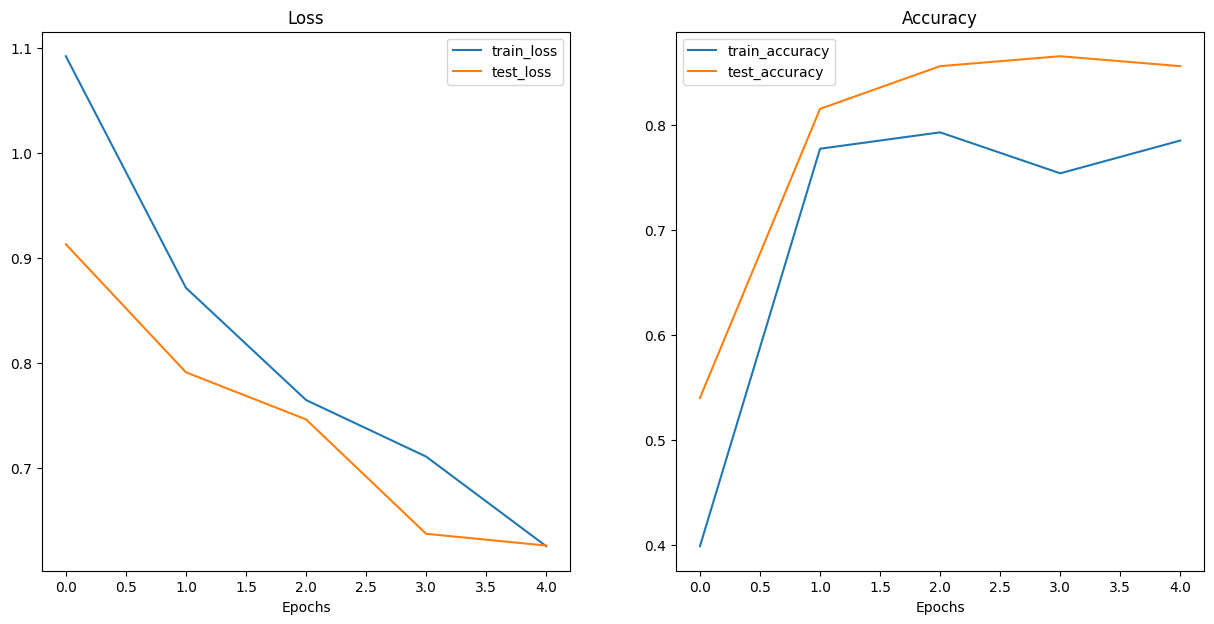

In [30]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py","wb") as f:
    import requests
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(requests.content)
  from helper_functions import plot_loss_curves

## plot the closs curves results
plot_loss_curves(results)

### 5.1. Training the model for longer and plotting the loss curves

In [31]:
## import train function
from going_modular.going_modular import engine

## set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## start the timer
from timeit import default_timer as timer
start_time = timer()

## setup training
results_2 = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total Training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5289 | train_acc: 0.9258 | test_loss: 0.5675 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4793 | train_acc: 0.9297 | test_loss: 0.5215 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4518 | train_acc: 0.9219 | test_loss: 0.5251 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.4759 | train_acc: 0.8398 | test_loss: 0.4815 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.4072 | train_acc: 0.9570 | test_loss: 0.4943 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.4402 | train_acc: 0.8203 | test_loss: 0.4729 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.4078 | train_acc: 0.9453 | test_loss: 0.4560 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.4280 | train_acc: 0.8320 | test_loss: 0.4499 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5003 | train_acc: 0.8242 | test_loss: 0.4426 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.4109 | train_acc: 0.8320 | test_loss: 0.3863 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3490 | train_acc: 0.9453 | test_loss: 0.4121 | test_acc: 0.8456
Epoch: 12 | train_l

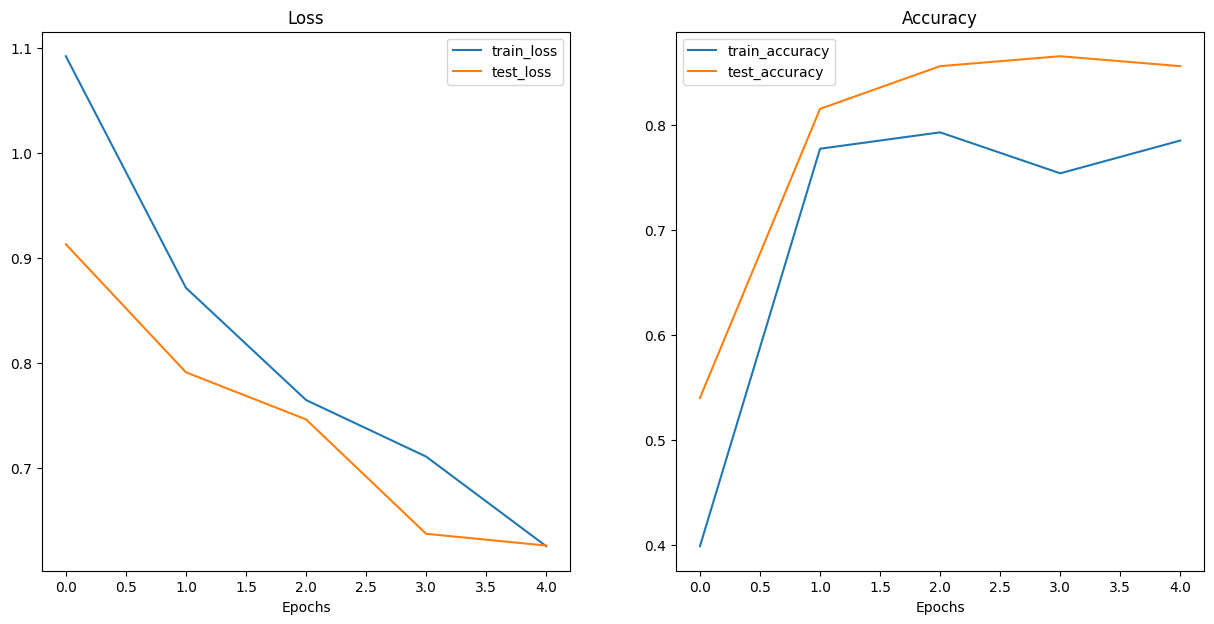

In [32]:
plot_loss_curves(results)

## 6. Make predictions on test images

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` with a few tweaked steps.

In [38]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(
    model:torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device=device
    ):

  ## 2. open image
  img = Image.open(image_path)

  ## 3. Create transformation for image (if one dosent exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
      transforms.Resize(image_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])
    ])

  ## Predict on image

  ## 4. Make sure the model is on the target device
  model.to(device)

  ## 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  #9. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}") ## taken the max here bc it is a tensor
  plt.axis(False);


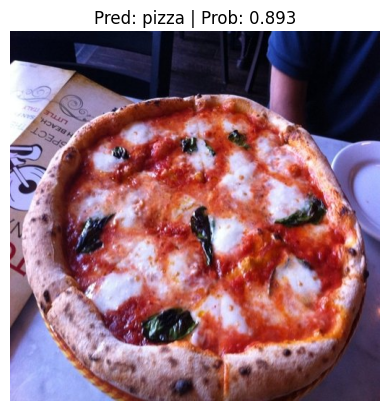

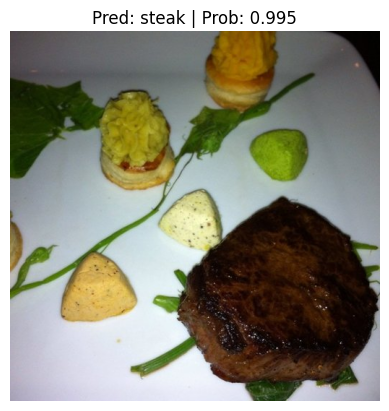

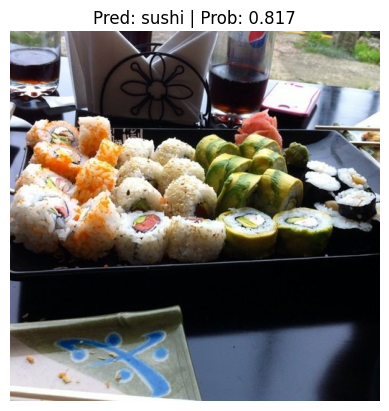

In [46]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_path_sample = random.sample(test_image_path_list,k=num_images_to_plot)

for image_path in test_path_sample:
  pred_and_plot_image(model=model,
                    image_path=image_path,
                    class_names = class_names,
                    image_size=(224,224),
                      device=device
                    )

The results are much better than the TinyVGG

In [55]:
## working of the max function
tensor = torch.tensor([[12.343,123.33434,12322]])

In [56]:
tensor.max()

tensor(12322.)

### 6.1. Making predictions on custom images

In [65]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print("Downloading Pizza dad data.... ")
    f.write(request.content)

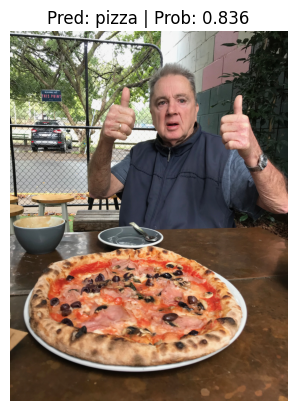

In [66]:
## Predicting on the custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names = class_names,
                    )